In [20]:
# PUBG: EDA → 전처리 → 모델 학습/평가 (Clean Ver.)

# 0) Imports
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [21]:
# 1) 데이터 로드 & 기본 확인
print(os.listdir("/kaggle/input"))
pubg = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/train_V2.csv")

print(pubg.shape, "rows, cols")
print(pubg.isnull().sum().sort_values(ascending=False).head(10))  # 결측치 상위 10개
print(pubg["matchType"].value_counts().head())

['pubg-finish-placement-prediction']
(4446966, 29) rows, cols
winPlacePerc       1
matchType          0
winPoints          0
weaponsAcquired    0
walkDistance       0
vehicleDestroys    0
teamKills          0
swimDistance       0
roadKills          0
rideDistance       0
dtype: int64
matchType
squad-fpp    1756186
duo-fpp       996691
squad         626526
solo-fpp      536762
duo           313591
Name: count, dtype: int64


In [22]:
# === 핵심 타깃 결측행은 드롭 (0 대치보다 안전)
pubg = pubg.dropna(subset=["winPlacePerc"]).reset_index(drop=True)

In [23]:
# 2) 간단 EDA (히트맵 + 스캐터 행렬)
def plot_heatmap(corrmat, title="Correlation Heatmap"):
    sns.set(style="white")
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # np.bool -> bool (FutureWarning 대응)
    mask = np.zeros_like(corrmat, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize=(16, 14))
    ax = sns.heatmap(
        corrmat, mask=mask, cmap=cmap,
        vmin=-1, vmax=1, center=0,
        square=True, cbar_kws={"shrink": 0.6},
        annot=False  # 보기만 할 거면 False가 빠르고 깔끔
    )
    ax.set_title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


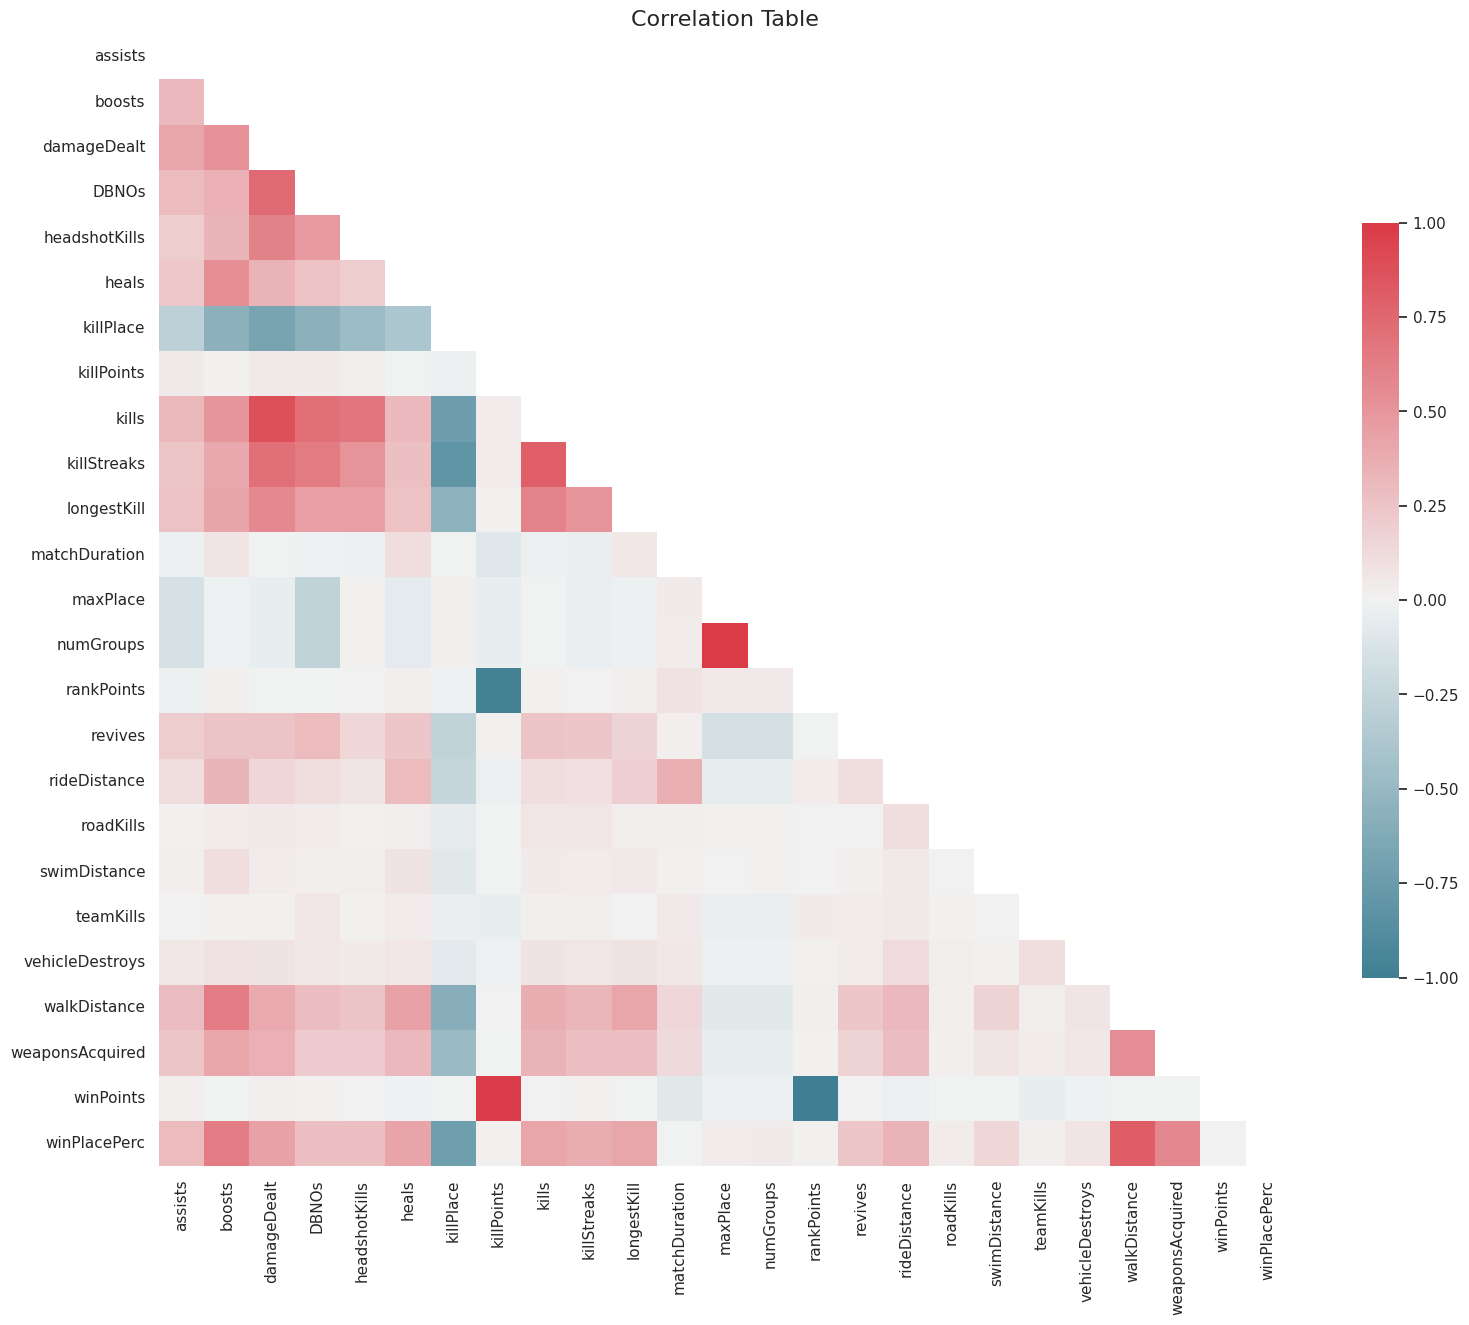

In [24]:
# 숫자형 열만 골라 상관계수 계산 (pandas 버전 관계없이 안전)
num_df = pubg.select_dtypes(include=np.number)
corr = num_df.corr()
plot_heatmap(corr, "Correlation Table")

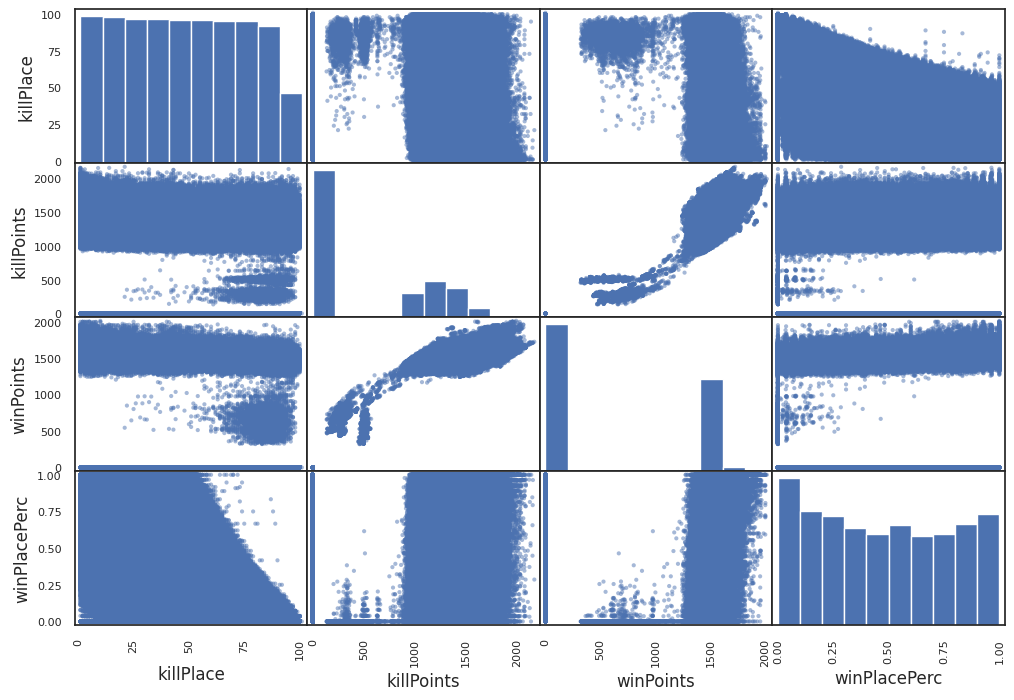

In [25]:
# 가벼운 산점도 행렬(변수 4개만)
scatter_matrix(pubg[["killPlace", "killPoints", "winPoints", "winPlacePerc"]], figsize=(12, 8))
plt.show()

In [26]:
# 3) 학습/테스트 분할 (matchType 기준 층화: 분포 유지 목적)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for tr_idx, te_idx in split.split(pubg, pubg["matchType"]):
    strat_train_set = pubg.loc[tr_idx].copy()
    strat_test_set  = pubg.loc[te_idx].copy()

In [27]:
# 4) 피처/타깃 분리 + 더미 인코딩
#   - 명시적으로 타깃 제외(인덱스로 자르는 방식 방지)
cols_to_drop = ["Id", "groupId", "matchId", "matchType", "winPlacePerc"]
cols_to_fit  = [c for c in pubg.columns if c not in cols_to_drop]

X_train = strat_train_set[cols_to_fit].copy()
y_train = strat_train_set["winPlacePerc"].copy()

X_test  = strat_test_set[cols_to_fit].copy()
y_test  = strat_test_set["winPlacePerc"].copy()

In [28]:
# matchType 원-핫 인코딩 + 열 정렬(훈련/테스트 일치)
train_dum = pd.get_dummies(strat_train_set["matchType"])
test_dum  = pd.get_dummies(strat_test_set["matchType"])

X_train = pd.concat([X_train, train_dum], axis=1)
X_test  = pd.concat([X_test,  test_dum],  axis=1).reindex(columns=X_train.columns, fill_value=0)

In [29]:
# 5) 모델 학습 & 평가
def rmse_cv(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cv)
    rmse = np.sqrt(-scores)
    return rmse

In [30]:
# (a) 의사결정나무
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

print("\n[DecisionTree]")
print("Train R2:", dt.score(X_train, y_train))
print("Test  R2:", dt.score(X_test,  y_test))

dt_rmse = rmse_cv(DecisionTreeRegressor(random_state=42), X_train, y_train, cv=5)
print("CV RMSE (mean ± std):", dt_rmse.mean(), "±", dt_rmse.std())


[DecisionTree]
Train R2: 0.999946219034977
Test  R2: 0.8567796159584599
CV RMSE (mean ± std): 0.11665895868143279 ± 0.0001646332974916091


In [ ]:
# (b) 랜덤포레스트 (가볍게 100트리)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print("\n[RandomForest]")
print("Train R2:", rf.score(X_train, y_train))
print("Test  R2:", rf.score(X_test,  y_test))

rf_rmse = rmse_cv(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), X_train, y_train, cv=5)
print("CV RMSE (mean ± std):", rf_rmse.mean(), "±", rf_rmse.std())

In [ ]:
# 6)테스트 RMSE 직접 확인
y_pred = rf.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("\nTest RMSE (RF):", test_rmse)

현재 완료된 코드까지만 제출합니다ㅠ